In [1]:
from pathlib import Path
import sys
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import os

# --- Locate project root & add src/ to sys.path ---
notebook_dir = Path().resolve()
project_root = notebook_dir.parents[0]      # eirgrid-pipeline/
src_path = project_root / "src"

print("notebook_dir:", notebook_dir)
print("project_root:", project_root)
print("src_path:", src_path)

if not src_path.exists():
    raise FileNotFoundError(f"src folder not found at: {src_path}")

if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

print("src contents:", os.listdir(src_path))

# --- Import warehouse functions ---
from warehouse.readings import get_all_metrics_wide, get_latest_complete_local_day
print("Imported get_all_metrics_wide OK")


notebook_dir: C:\Users\roryo\Documents\DATA-Portfolio\eirgrid-pipeline\notebooks
project_root: C:\Users\roryo\Documents\DATA-Portfolio\eirgrid-pipeline
src_path: C:\Users\roryo\Documents\DATA-Portfolio\eirgrid-pipeline\src
src contents: ['dashboard', 'ingest', 'models', 'pipeline', 'transform', 'warehouse']
Imported get_all_metrics_wide OK


In [2]:
latest_day = get_latest_complete_local_day()
print("Using latest complete local day:", latest_day)

df = get_all_metrics_wide(latest_day, latest_day)
df.head()

Using latest complete local day: 2025-11-26


,ts_utc,wind_actual,solar_actual,demand_actual
0,2025-11-26 00:00:00+00:00,2141.0,0.0,4753.0
1,2025-11-26 00:15:00+00:00,2226.0,0.0,4711.0
2,2025-11-26 00:30:00+00:00,2272.0,0.0,4631.0
3,2025-11-26 00:45:00+00:00,2379.0,0.0,4552.0
4,2025-11-26 01:00:00+00:00,2343.0,0.0,4502.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   ts_utc         96 non-null     datetime64[ns, UTC]
 1   wind_actual    96 non-null     float64            
 2   solar_actual   96 non-null     float64            
 3   demand_actual  96 non-null     float64            
dtypes: datetime64[ns, UTC](1), float64(3)
memory usage: 3.1 KB


Text(0, 0.5, 'MW')

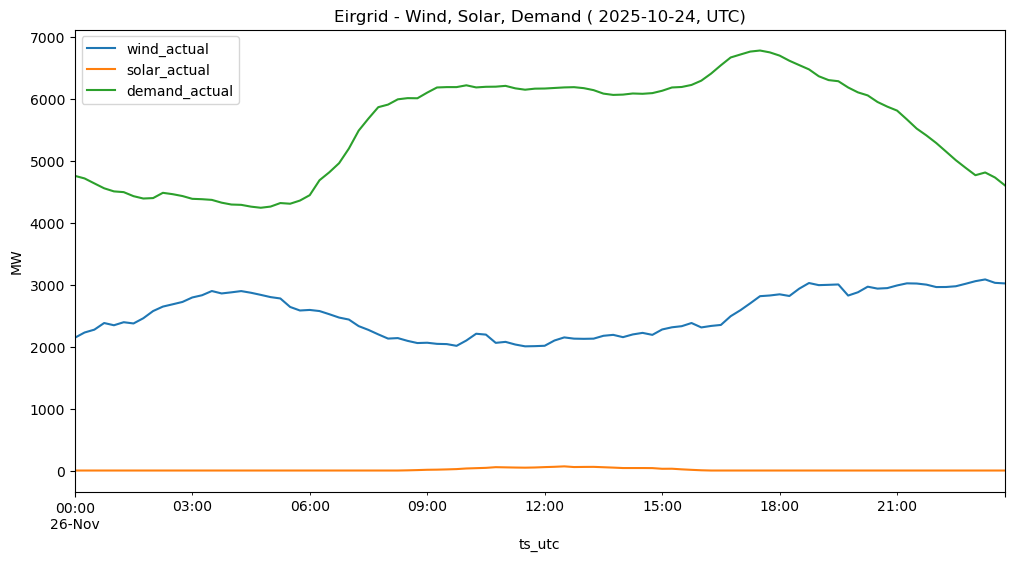

In [4]:
df_plot = df.set_index("ts_utc")

ax = df_plot[["wind_actual", "solar_actual", "demand_actual"]].plot(figsize=(12,6))
ax.set_title("Eirgrid - Wind, Solar, Demand ( 2025-10-24, UTC)")
ax.set_ylabel("MW")

In [5]:
# compute interval length in hours from the data itself
dt = df["ts_utc"].diff().dropna()
interval_hours = dt.median().total_seconds() / 3600
interval_hours


0.25

In [6]:
wind_mwh = (df["wind_actual"] * interval_hours).sum()
solar_mwh = (df["solar_actual"] * interval_hours).sum()
demand_mwh = (df["demand_actual"] * interval_hours).sum()

print(f"Total Wind (MWh): {wind_mwh}")
print(f"Total Solar (MWh): {solar_mwh}")
print(f"Total Demand (MWh): {demand_mwh}")


Total Wind (MWh): 60528.5
Total Solar (MWh): 286.0
Total Demand (MWh): 133258.25


In [7]:
# wind stats
wind_min  = df["wind_actual"].min()
wind_max  = df["wind_actual"].max()
wind_mean = df["wind_actual"].mean()

# solar stats
solar_min  = df["solar_actual"].min()
solar_max  = df["solar_actual"].max()
solar_mean = df["solar_actual"].mean()

# demand stats
demand_min  = df["demand_actual"].min()
demand_max  = df["demand_actual"].max()
demand_mean = df["demand_actual"].mean()

# peak times (UTC)
t_peak_wind   = df.loc[df["wind_actual"].idxmax(),   "ts_utc"]
t_peak_solar  = df.loc[df["solar_actual"].idxmax(),  "ts_utc"]
t_peak_demand = df.loc[df["demand_actual"].idxmax(), "ts_utc"]

t_peak_wind, t_peak_solar, t_peak_demand


(Timestamp('2025-11-26 23:15:00+0000', tz='UTC'),
 Timestamp('2025-11-26 12:30:00+0000', tz='UTC'),
 Timestamp('2025-11-26 17:30:00+0000', tz='UTC'))

In [8]:
renewables_share = ((wind_mwh + solar_mwh) / demand_mwh) * 100
print(f"Renewables share: {renewables_share}%")


Renewables share: 45.636574095787694%


In [10]:
summary = {
    "date": latest_day,  # the date you queried

    "wind_min_MW": wind_min,
    "wind_max_MW": wind_max,
    "wind_mean_MW": wind_mean,
    "wind_MWh": wind_mwh,

    "solar_min_MW": solar_min,
    "solar_max_MW": solar_max,
    "solar_mean_MW": solar_mean,
    "solar_MWh": solar_mwh,

    "demand_min_MW": demand_min,
    "demand_max_MW": demand_max,
    "demand_mean_MW": demand_mean,
    "demand_MWh": demand_mwh,

    "peak_wind_utc": t_peak_wind,
    "peak_solar_utc": t_peak_solar,
    "peak_demand_utc": t_peak_demand,

    "renewables_share": round(renewables_share, 4),
}

summary_df = pd.DataFrame([summary])
summary_df


,date,wind_min_MW,wind_max_MW,wind_mean_MW,wind_MWh,solar_min_MW,solar_max_MW,solar_mean_MW,solar_MWh,demand_min_MW,demand_max_MW,demand_mean_MW,demand_MWh,peak_wind_utc,peak_solar_utc,peak_demand_utc,renewables_share
0,2025-11-26,2003.0,3082.0,2522.020833,60528.5,0.0,67.0,11.916667,286.0,4238.0,6774.0,5552.427083,133258.25,2025-11-26 23:15:00+00:00,2025-11-26 12:30:00+00:00,2025-11-26 17:30:00+00:00,45.6366
